<a href="https://colab.research.google.com/github/mrpintime/Gaussian-Mixture-Model/blob/main/Image_Dimensionality_Reduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gaussian-Mixture-Model
Created By Moein aka Mrpintime

# Description  

We use Gaussian Mixture Model (GMM) as a clustering algorithm to segmentate the pixels of a picture, and also we replace value of points of each segment with value of corresponded centroid.

We can see how this model help us to reduce volume of a picture but still has enough information from original picture to recognize it.
GMM is a Soft clustering algorithms can cluster data in partially one cluster and partially others.  

We can use a GMM to segment an image into K regions (n_components = K) according to significant colors.

Each pixel would be a data point with three features (r, g, b) (Or 1 feature if greyscale).

In [6]:
import numpy as np
import cv2
from sklearn.mixture import GaussianMixture as GMM
import matplotlib.pyplot as plt
%matplotlib inline

Read image.

In [8]:
img = cv2.imread('/content/drive/MyDrive/Images/baby_leopard.jpg')

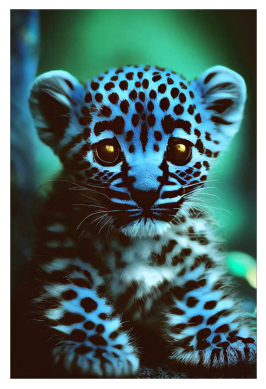

In [9]:
plt.axis("off")
plt.imshow(img)
plt.show()

The displayed image is not real one and this happens because OpenCV represents RGB images as multi-dimensional NumPy array but in the reverse order(BGR). This means that images are actually represented in BGR order rather than RGB. This can be corrected by converting BGR to RGB.

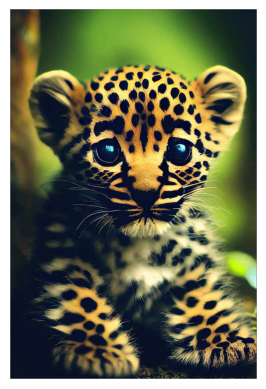

In [10]:
plt.axis("off")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

Save new image with correct RGB order.

In [11]:
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Reshape Image

In [12]:
# These are data of our picture
img[0:1], img.shape

(array([[[182, 183, 178],
         [119, 120, 115],
         [148, 149, 144],
         ...,
         [154, 164, 173],
         [100, 109, 116],
         [178, 185, 191]]], dtype=uint8),
 (832, 555, 3))

If img is greyscale, then change to .reshape(-1, 1) and if it was RGB we change it to reshape(-1, 3):

In [13]:
x = img.reshape(-1, 3)

In [14]:
x.shape

(461760, 3)

In [15]:
x

array([[182, 183, 178],
       [119, 120, 115],
       [148, 149, 144],
       ...,
       [167, 167, 167],
       [111, 111, 111],
       [187, 187, 187]], dtype=uint8)

The number of components; n > 0, positive integer:


In [16]:
n = 3

In [17]:
gm_model = GMM(n_components=n, covariance_type='full')
gm_model.fit(x)

# predicted each pixels belong to which cluster.
labels = gm_model.predict(x)

# create a matrix with shape of our image sets
segment = np.zeros(x.shape)

#Assign each pixels in corresponded cluster into their centroid value
for label in range(n):
    segment[labels == label] = gm_model.means_[label]

# change shape for save it into picture.
segment = segment.reshape(img.shape).astype(np.uint8)

Let's see our new image

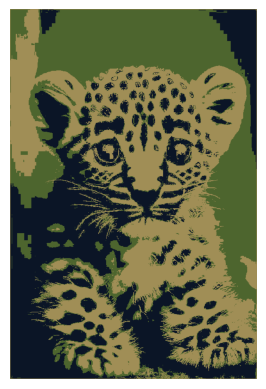

In [22]:
plt.imshow(segment)
plt.axis('off')
plt.show()

# Change picture to black and white

First we have to find represented values for black and white in RGB

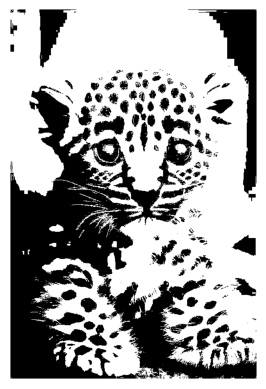

In [23]:
rgb_values = [(0,0,0), (255,255,255)] #black and white

# number of centroids or components in gaussian mixture model
# for black white we set it to two
n = 2

gmm = GMM(covariance_type='full', n_components=n, random_state=25)
gmm.fit(x)

# predicted each pixels belong to which cluster.
labels = gmm.predict(x)

bw_img = x.copy()

# Clusters in labels variable annotate from 0 to whatever your maximum number of component is.
# Change colors to black and white
for i in np.unique(labels):
  bw_img[labels == i, :] = rgb_values[i]

# reshape new image and display it

bw_img = bw_img.reshape(img.shape)

plt.imshow(bw_img)
plt.axis('off')
plt.show()

# How algorithm clustered data   
 We want to see how algorithm clustered data and what objects are on same cluster.

In [64]:
x.dtype

dtype('uint8')

In [65]:
# create GMM model with 6 components

gmm_6 = GMM(n_components=6, covariance_type='full')
gmm_6.fit(x.astype('float'))

labels = gmm_6.predict(x)

In [66]:
result = []
for label in np.unique(labels):
  zeros = np.zeros(x.shape)
  zeros[labels==label, :] = gmm_6.means_[label]
  result.append(zeros.reshape(img.shape).astype('uint8'))

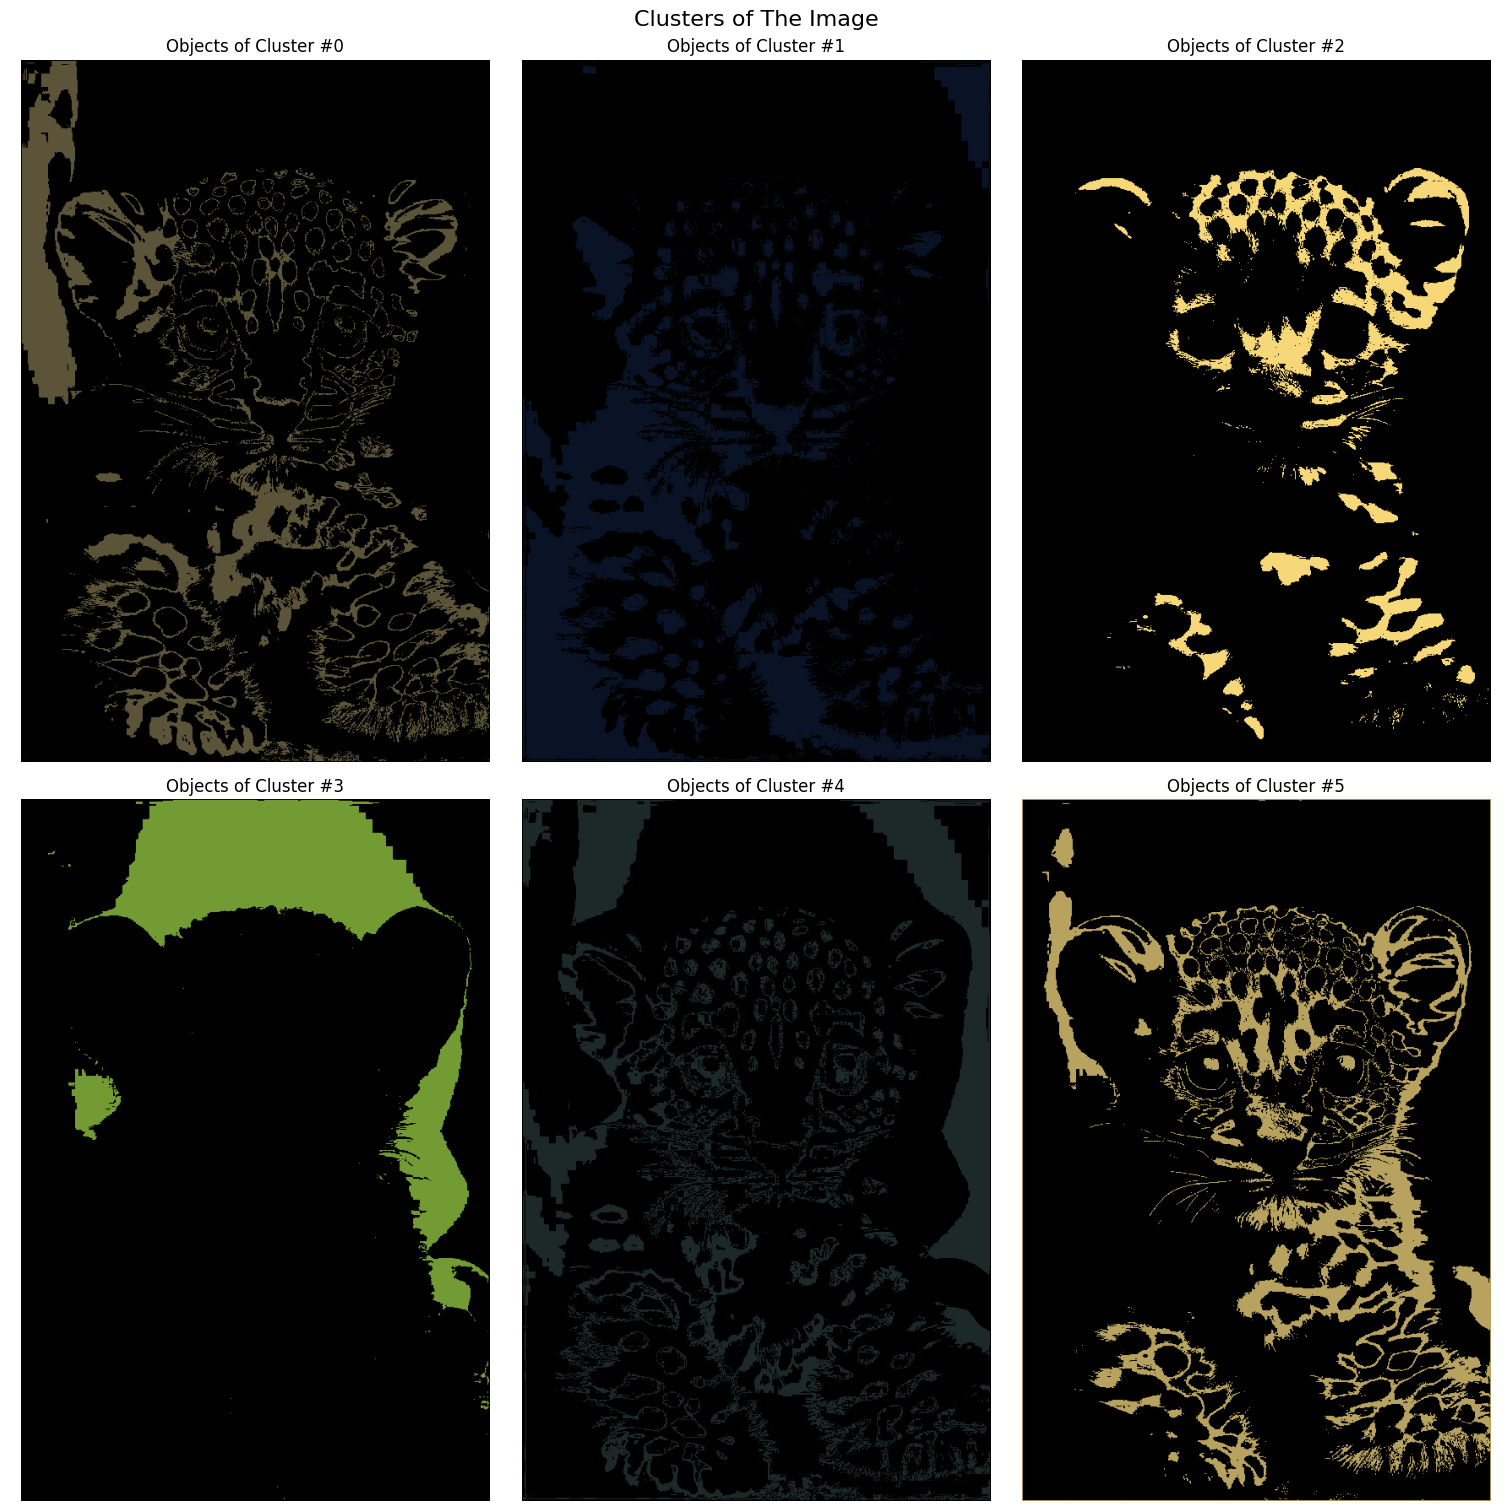

In [68]:
p = 0
r,c = 2 , 3
fig = plt.figure(figsize=(15,15),  constrained_layout=True)
plt.axis('off')
ax = fig.subplots(r,c)
fig.suptitle('Clusters of The Image', fontsize=16)
for i in range(r):
  for j in range(c):
    ax[i, j].set_title(f'Objects of Cluster #{p}')
    ax[i, j].axis('off')
    ax[i, j].imshow(result[p])
    p += 1
# plt.tight_layout
# plt.title('Clusters of The Image', fontsize=16)
plt.show()

# Use silhouette score to find best K

We want to find optimum k between 2 to 10

Install cuML to use gpu when calculating silhouette_score

In [ ]:
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/pip-install.py

In [ ]:
import cuml

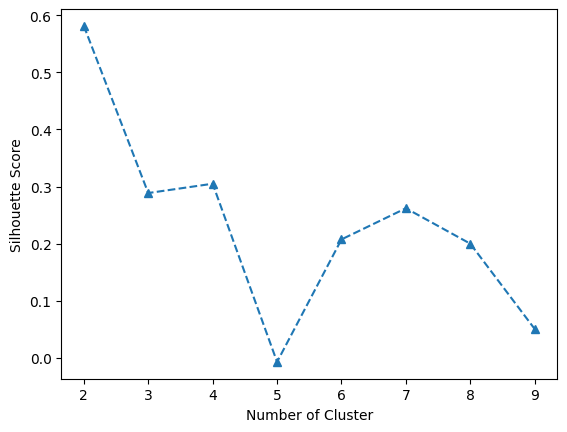

In [ ]:
eval_silhouette = []

k_range = range(2, 10)

for i in k_range:
  gmm = GMM(n_components=i, covariance_type='tied', init_params='k-means++')
  gmm.fit(x)
  # extract labels
  labels = gmm.predict(x)

  score = cuml.metrics.cluster.silhouette_score(x.astype(np.float32), labels, metric='euclidean')

  eval_silhouette.append(score)

# plot the silhouette score
plt.plot(k_range, eval_silhouette, ls='--', marker='^')
plt.xlabel('Number of Cluster')
plt.ylabel('Silhouette Score')
plt.show()

# Conclusion:  
by chance we have best score when we define 2 components.  
So what it means:
> The silhouette value is a measure of how similar an object is to its own cluster compared to other clusters. The silhouette ranges from −1 to +1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters.